In [1]:
import os, ssl, certifi
ca = certifi.where()

# Force CA bundle usage
os.environ["SSL_CERT_FILE"] = ca
os.environ["REQUESTS_CA_BUNDLE"] = ca
os.environ["CURL_CA_BUNDLE"] = ca

# Patch urllib SSL context
import ssl, certifi
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date
import meteostat as ms
import matplotlib.pyplot as plt

try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **kwargs: x

print("CA bundle:", ca)

CA bundle: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/.venv/lib/python3.13/site-packages/certifi/cacert.pem


In [2]:
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data_raw"
DATA_PROCESSED = ROOT / "data_processed"
DATA_PROCESSED.mkdir(exist_ok=True)

store_info = pd.read_csv(DATA_RAW / "store_info.csv")
perf = pd.read_csv(DATA_RAW / "store_performance_2018to2022.csv")

store_info.columns = store_info.columns.str.strip()
perf.columns = perf.columns.str.strip()

perf["invoice_date"] = pd.to_datetime(perf["invoice_date"], errors="coerce")
store_info["store_id"] = pd.to_numeric(store_info["store_id"], errors="coerce").astype("Int64")
perf["store_id"] = pd.to_numeric(perf["store_id"], errors="coerce").astype("Int64")

print("store_info:", store_info.shape)
print("perf:", perf.shape)
print("Perf date range:", perf["invoice_date"].min(), "to", perf["invoice_date"].max())
print("Perf unique stores:", perf["store_id"].nunique())

store_info: (439, 14)
perf: (773266, 5)
Perf date range: 2018-01-02 00:00:00 to 2022-12-31 00:00:00
Perf unique stores: 439


In [3]:
N_STORES = 8  # change to 5 or 10

valid_stores = (
    store_info.dropna(subset=["store_latitude", "store_longitude"])
    .merge(perf[["store_id"]].drop_duplicates(), on="store_id", how="inner")
    .drop_duplicates(subset=["store_id"])
)

pilot_stores = valid_stores.head(N_STORES).copy()
pilot_store_ids = pilot_stores["store_id"].astype(int).tolist()

pilot_perf = perf[perf["store_id"].isin(pilot_store_ids)].copy()

start_d = pilot_perf["invoice_date"].min().date()
end_d = pilot_perf["invoice_date"].max().date()

print("Pilot store_ids:", pilot_store_ids)
print("Pilot perf rows:", len(pilot_perf))
print("Pilot date range:", start_d, "to", end_d)

Pilot store_ids: [79609, 84321, 84832, 84855, 84954, 84970, 88322, 88342]
Pilot perf rows: 13969
Pilot date range: 2018-01-02 to 2022-12-31


In [4]:
def fetch_store_daily_weather_meteostat(lat, lon, start_d, end_d, station_limit=5) -> pd.DataFrame:
    """
    Returns daily weather DataFrame with a datetime column named 'invoice_date'.
    Uses nearby stations. No interpolation (more stable).
    """
    point = ms.Point(float(lat), float(lon))
    stations = ms.stations.nearby(point, limit=station_limit)

    if stations is None or stations.empty:
        return pd.DataFrame()

    ts = ms.daily(stations, start_d, end_d)
    df = ts.fetch()

    if df is None or df.empty:
        return pd.DataFrame()

    df = df.reset_index().rename(columns={"time": "invoice_date"})
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])
    return df

In [5]:
weather_frames = []
skipped = []

for _, row in tqdm(pilot_stores.iterrows(), total=len(pilot_stores), desc="Pulling Meteostat weather"):
    sid = int(row["store_id"])
    w = fetch_store_daily_weather_meteostat(
        row["store_latitude"], row["store_longitude"], start_d, end_d, station_limit=5
    )

    if w.empty:
        skipped.append(sid)
        continue

    w["store_id"] = sid
    keep = ["store_id", "invoice_date", "tavg", "tmin", "tmax", "prcp", "snow", "wspd"]
    w = w[[c for c in keep if c in w.columns]].copy()
    weather_frames.append(w)

print("Stores weather pulled:", len(weather_frames))
print("Skipped stores:", skipped)

weather = pd.concat(weather_frames, ignore_index=True)
print("Weather rows:", len(weather))
print("Weather columns:", list(weather.columns))
weather.head()

Pulling Meteostat weather: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]

Stores weather pulled: 8
Skipped stores: []
Weather rows: 46510
Weather columns: ['store_id', 'invoice_date', 'tmin', 'tmax', 'prcp', 'wspd']


,store_id,invoice_date,tmin,tmax,prcp,wspd
0,79609,2018-01-02,-19.3,-6.6,0.0,5.4
1,79609,2018-01-03,-15.5,-0.5,0.0,13.7
2,79609,2018-01-04,-13.2,-4.9,0.0,16.9
3,79609,2018-01-05,-14.9,-7.1,0.0,9.4
4,79609,2018-01-06,-18.8,-5.5,0.0,4.0


In [6]:
merged = pilot_perf.merge(weather, on=["store_id", "invoice_date"], how="left")

print("Merged rows:", len(merged))
print("Duplicates (store_id, invoice_date):", merged.duplicated(["store_id","invoice_date"]).sum())

if "prcp" in merged.columns:
    print("Missing % prcp:", round(merged["prcp"].isna().mean() * 100, 2))
if "tavg" in merged.columns:
    print("Missing % tavg:", round(merged["tavg"].isna().mean() * 100, 2))

merged.head()

Merged rows: 44816
Duplicates (store_id, invoice_date): 30847
Missing % prcp: 30.9


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tmin,tmax,prcp,wspd
0,2020-03-11,84970,42,38,3,6.7,13.3,0.0,8.6
1,2020-03-11,84970,42,38,3,7.0,15.0,<NA>,6.3
2,2020-03-20,84321,64,57,4,5.6,21.7,3.8,24.5
3,2020-03-20,84321,64,57,4,8.3,23.9,<NA>,23.3
4,2020-03-20,84321,64,57,4,10.0,23.0,<NA>,19.6


In [8]:
merged["dow"] = merged["invoice_date"].dt.dayofweek
merged["month"] = merged["invoice_date"].dt.month
merged["is_weekend"] = (merged["dow"] >= 5).astype(int)

if "prcp" in merged.columns:
    merged["is_rain"] = (merged["prcp"].fillna(0) > 0).astype(int)

if "tmin" in merged.columns:
    merged["is_freezing"] = (merged["tmin"].fillna(999) <= 0).astype(int)

feature_cols = ["dow", "month", "is_weekend"]
for c in ["tavg", "tmin", "tmax", "prcp", "wspd", "snow", "is_rain", "is_freezing"]:
    if c in merged.columns:
        feature_cols.append(c)

print("Feature columns:", feature_cols)
merged.head()

Feature columns: ['dow', 'month', 'is_weekend', 'tmin', 'tmax', 'prcp', 'wspd', 'is_rain', 'is_freezing']


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tmin,tmax,prcp,wspd,dow,month,is_weekend,is_rain,is_freezing
0,2020-03-11,84970,42,38,3,6.7,13.3,0.0,8.6,2,3,0,0,0
1,2020-03-11,84970,42,38,3,7.0,15.0,<NA>,6.3,2,3,0,0,0
2,2020-03-20,84321,64,57,4,5.6,21.7,3.8,24.5,4,3,0,1,0
3,2020-03-20,84321,64,57,4,8.3,23.9,<NA>,23.3,4,3,0,0,0
4,2020-03-20,84321,64,57,4,10.0,23.0,<NA>,19.6,4,3,0,0,0


In [9]:
# Train: < 2022, Validate: >= 2022 (good default for 2018–2022 data)
cutoff = pd.Timestamp("2022-01-01")

train = merged[merged["invoice_date"] < cutoff].copy()
valid = merged[merged["invoice_date"] >= cutoff].copy()

print("Train:", train.shape, train["invoice_date"].min().date(), "to", train["invoice_date"].max().date())
print("Valid:", valid.shape, valid["invoice_date"].min().date(), "to", valid["invoice_date"].max().date())

Train: (33926, 14) 2018-01-02 to 2021-12-31
Valid: (10890, 14) 2022-01-02 to 2022-12-31


In [10]:
target = "invoice_count"

# Baseline: average invoice_count per (store_id, dow) from training
baseline_table = (
    train.groupby(["store_id", "dow"])[target]
    .mean()
    .reset_index()
    .rename(columns={target: "pred"})
)

valid_pred = valid.merge(baseline_table, on=["store_id", "dow"], how="left")

# Fallback: store average from training (if (store_id,dow) missing)
store_avg = train.groupby("store_id")[target].mean().rename("store_avg").reset_index()
valid_pred = valid_pred.merge(store_avg, on="store_id", how="left")
valid_pred["pred"] = valid_pred["pred"].fillna(valid_pred["store_avg"])

In [11]:
y_true = valid_pred[target].astype(float)
y_pred = valid_pred["pred"].astype(float)

mae = np.mean(np.abs(y_true - y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100

print("Baseline: store_id + day-of-week mean")
print("MAE :", round(mae, 3))
print("MAPE:", round(mape, 3), "%")

Baseline: store_id + day-of-week mean
MAE : 9.32
MAPE: 21.782 %


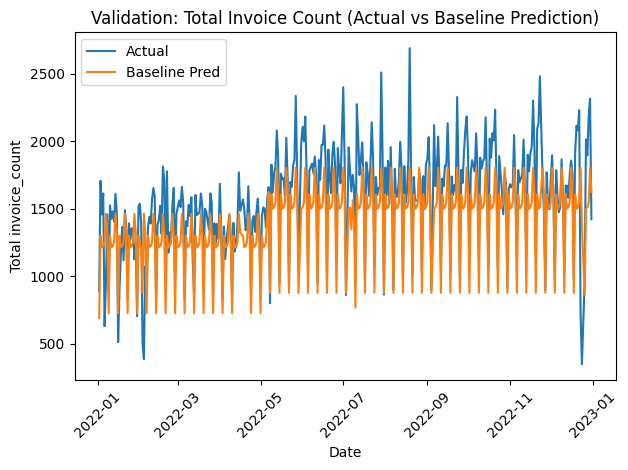

In [12]:
daily_actual = valid_pred.groupby("invoice_date", as_index=False)[target].sum()
daily_pred = valid_pred.groupby("invoice_date", as_index=False)["pred"].sum()

plt.figure()
plt.plot(daily_actual["invoice_date"], daily_actual[target], label="Actual")
plt.plot(daily_pred["invoice_date"], daily_pred["pred"], label="Baseline Pred")
plt.title("Validation: Total Invoice Count (Actual vs Baseline Prediction)")
plt.xlabel("Date")
plt.ylabel("Total invoice_count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
merged_out = DATA_PROCESSED / "merged_model_ready_pilot_meteostat.csv"
pred_out = DATA_PROCESSED / "baseline_predictions_pilot.csv"
train_out = DATA_PROCESSED / "train_pilot.csv"
valid_out = DATA_PROCESSED / "valid_pilot.csv"

merged.to_csv(merged_out, index=False)
valid_pred.to_csv(pred_out, index=False)
train.to_csv(train_out, index=False)
valid.to_csv(valid_out, index=False)

print("Saved:", merged_out)
print("Saved:", pred_out)
print("Saved:", train_out)
print("Saved:", valid_out)

Saved: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/merged_model_ready_pilot_meteostat.csv
Saved: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/baseline_predictions_pilot.csv
Saved: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/train_pilot.csv
Saved: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/valid_pilot.csv
